# Task 1 - Image Classification

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

print("Torch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("Torch CUDA available:", torch.cuda.is_available())

Torch version: 2.8.0+cu129
Torchvision version: 0.23.0+cu129
Torch CUDA available: True


# Prepare Dataset

In [2]:
cifar10_train = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=torchvision.transforms.ToTensor()
)

cifar10_test = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=torchvision.transforms.ToTensor()
)

val_size = 10000
train_size = len(cifar10_train) - val_size
cifar10_train, cifar10_val = torch.utils.data.random_split(cifar10_train, [train_size, val_size])

print("Training set size:", len(cifar10_train))
print("Validation set size:", len(cifar10_val))
print("Test set size:", len(cifar10_test))

Training set size: 40000
Validation set size: 10000
Test set size: 10000


In [3]:
cifar10_train

In [4]:
cifar10_val

In [5]:
cifar10_test

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()

torch.Size([3, 32, 32]) 4
torch.Size([3, 32, 32]) 7
torch.Size([3, 32, 32]) 4
torch.Size([3, 32, 32]) 7
torch.Size([3, 32, 32]) 4
torch.Size([3, 32, 32]) 1
torch.Size([3, 32, 32]) 7
torch.Size([3, 32, 32]) 3
torch.Size([3, 32, 32]) 1
torch.Size([3, 32, 32]) 6


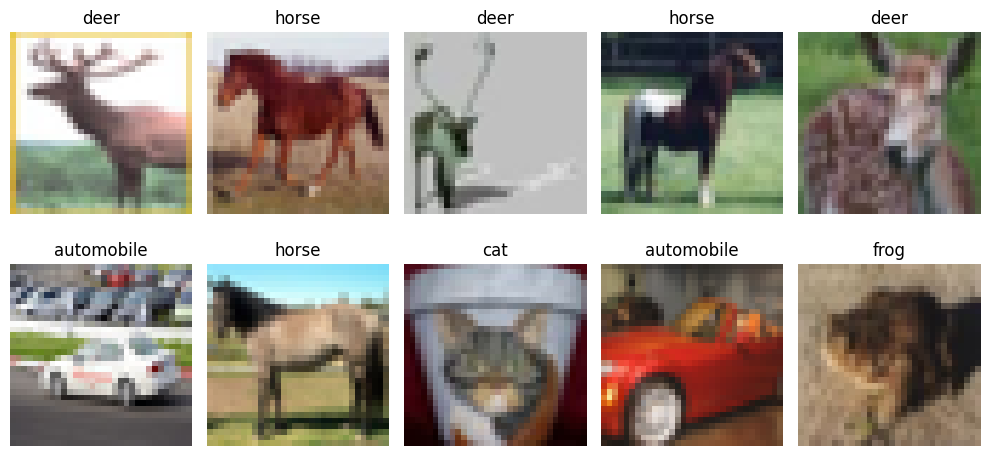

In [6]:
plt.figure(figsize=(10, 5))
for i in range(10):
    img, label = cifar10_train[i]  # Each element is (image_tensor, label)
    print(img.shape, label)
    plt.subplot(2, 5, i + 1)
    plt.imshow(img.permute(1, 2, 0))  # Convert from (C, H, W) → (H, W, C)
    plt.title(cifar10_train.dataset.classes[label])  # Convert numeric label to class name
    plt.axis("off")

plt.tight_layout()
plt.show()

# Part 1 - My Model

## My Model Architecture

In [7]:
class MyCNNModel(torch.nn.Module):
    def __init__(self):
        super(MyCNNModel, self).__init__()
        # Define layers

        # Convolutional layer 1
        # input shape: (3, 32, 32) for CIFAR-10 images
        # - 3 input channels (RGB)
        # - 32x32 image size (height x width)
        # Convolve with (number of filters, number of channels, filter height, filter width)
        # - 16 filters
        # - each filter has 3 channels (RGB)
        # - each filter is 3x3 (height x width)
        # Output shape: (16, 32, 32)
        # - Each of the 16 filters produces 3 channels convolved output
        #   then summed up to produce a single channel output, resulting in 16 output channels
        # - Padding of 1 is used to maintain the spatial dimensions (32x32)
        # Total parameters = 3 (input channels) * 3 * 3 (kernel size) * 16 (output channels) + 16 (biases) = 448
        # Output dimension calculation:
        # - H_out = (H_in - K + 2P)/S + 1 = (32 - 3 + 2*1)/1 + 1 = 32
        #  where H_in = 32, P = padding = 1, S = stride = 1, K = kernel size = 3
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)

        # Pooling layer
        # Reduces each spatial dimension by a factor of 2
        # Input shape: (16, 32, 32)
        # Output shape: (16, 16, 16)
        # Total parameters = 0 (no learnable parameters in pooling)
        # Output dimension calculation:
        # - H_out = (H_in - K)/S + 1 = (32 - 2)/2 + 1 = 16
        #  where H_in = 32, K = kernel size = 2, S = stride = 2
        # Pooling does not change the number of channels
        # stride is set to 2 to downsample by a factor of 2, if set to 1x1, output size would be 31x31
        # It's common to use 2x2 pooling with stride 2 to reduce spatial dimensions by half
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Convolutional layer 2
        # Input shape: (16, 16, 16)
        # - 16 input channels from previous layer
        # - 16x16 image size (height x width)
        # Convolve with (number of filters, number of channels, filter height, filter width)
        # - 32 filters
        # - each filter has 16 channels (from previous layer)
        # - each filter is 3x3 (height x width)
        # Output shape: (32, 16, 16)
        # - Each of the 32 filters produces 16 channels convolved output
        #   then summed up to produce a single channel output, resulting in 32 output channels
        # - Padding of 1 is used to maintain the spatial dimensions (16x16)
        # Total parameters = 16 (input channels) * 3 * 3 (kernel size) * 32 (output channels) + 32 (biases) = 4,640
        self.conv2 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        # After conv2 and pooling, the output shape will be (32, 8, 8)
        self.flatten = torch.nn.Flatten()
        # Fully connected layer 1
        self.fc1 = torch.nn.Linear(in_features=32 * 8 * 8, out_features=128)
        self.fc2 = torch.nn.Linear(in_features=128, out_features=10)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))  # Reuse relu
        x = self.pool(x)  # Reuse pooling layer
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def calculate_trainable_parameters_by_layer(self):
        total_params = 0
        print("Trainable parameters by layer:")
        for name, param in self.named_parameters():
            if param.requires_grad:
                print(f"Layer: {name} = {param.numel()}")
                total_params += param.numel()
        print(f"Total trainable parameters: {total_params}")


## Training Loop

In [15]:
from sklearn.metrics import accuracy_score, f1_score


def train_model(train_loader, val_loader, model, criterion, optimizer, scheduler, num_epochs, device):
    # model.train() can be outside the epoch loop if no validation is done
    # but inside the loop is more flexible for future changes like adding validation
    # where model.eval() is needed before validation to set dropout/batchnorm layers to eval mode

    # Pytorch does not have built-in history tracking
    train_loss_history = []
    train_accuracy_history = []
    train_f1_history = []
    val_loss_history = []
    val_accuracy_history = []
    val_f1_history = []

    for epoch in range(num_epochs):
        # best practice to set model to training mode at the start of each epoch
        model.train()

        # Running loss for the epoch, reset at each epoch
        # The reason why we use running loss instead of just loss is that
        # loss.item() gives the loss for the current batch only.
        # To get the average loss over the entire epoch, we accumulate it.
        # This is especially useful when the dataset size is not perfectly divisible by the batch size.
        # It ensures that we account for all batches, including the last one which might be smaller.
        # We update weights after each batch, that means the loss is computed per batch,
        # then backpropagated, and weights are updated.
        # And then loss is calculated for the next batch with the updated weights, and so on.
        running_train_loss = 0.0

        train_predictions = []
        train_true_labels = []
        for images, labels in train_loader:
            # Put data on the correct device, both X and y
            images, labels = images.to(device), labels.to(device)

            # zero_grad() clears old gradients from the last step
            # so that forward pass can create a new backpropagation directed graph
            # that does not mix up gradients between batches.
            optimizer.zero_grad()

            # Forward pass to get predictions and generate backpropagation directed graph
            outputs = model(images)

            # Calculate loss of current batch
            loss = criterion(outputs, labels)

            # Calculate gradients of by traversing back the graph
            # and store them in the grad attributes of the parameters
            loss.backward()

            # Update model parameters using the calculated gradients
            # This is where "new_weights = old_weights - learning_rate * gradients" happens
            optimizer.step()

            # Accumulate running loss of each batch
            # loss.item() gets the scalar value of the loss tensor
            # This is used to compute average loss over the batches in the epoch
            running_train_loss += loss.item()

            train_predictions.extend(torch.max(outputs.data, 1)[1].cpu().numpy())
            train_true_labels.extend(labels.cpu().numpy())

        # Calculate average loss over the epoch
        avg_loss_over_epoch = running_train_loss / len(train_loader)
        train_accuracy_over_epoch = accuracy_score(train_true_labels, train_predictions)
        train_f1_over_epoch = f1_score(train_true_labels, train_predictions, average="weighted")

        # Append average loss to history for later plotting
        train_loss_history.append(avg_loss_over_epoch)
        train_accuracy_history.append(train_accuracy_over_epoch)
        train_f1_history.append(train_f1_over_epoch)

        # Validation phase
        running_val_loss = 0.0
        val_predictions = []
        val_true_labels = []

        model.eval()  # Set model to evaluation mode before validation
        with torch.no_grad():  # Disable gradient calculation for validation
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                # Forward pass without tracking gradients
                outputs = model(images)

                # Calculate validation loss of current batch
                val_loss = criterion(outputs, labels)

                # Accumulate running validation loss
                running_val_loss += val_loss.item()

                # Store predictions and true labels for accuracy and F1 score calculation
                val_predictions.extend(torch.max(outputs.data, 1)[1].cpu().numpy())
                val_true_labels.extend(labels.cpu().numpy())

        # Calculate average validation loss, accuracy, f1 over the epoch
        avg_val_loss_over_epoch = running_val_loss / len(val_loader)
        val_accuracy = accuracy_score(val_true_labels, val_predictions)
        val_f1 = f1_score(val_true_labels, val_predictions, average="weighted")

        val_loss_history.append(avg_val_loss_over_epoch)
        val_accuracy_history.append(val_accuracy)
        val_f1_history.append(val_f1)

        # Print epoch loss for monitoring
        print(
            f"Epoch [{epoch + 1}/{num_epochs}], "
            f"Loss: {avg_loss_over_epoch:.4f}, "
            f"Val Loss: {avg_val_loss_over_epoch:.4f}, "
            f"Val Acc: {val_accuracy:.4f}, Val F1: {val_f1:.4f}"
        )

        # Step the scheduler if provided and check for ReduceLROnPlateau

        if scheduler is not None:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(avg_val_loss_over_epoch)
            else:
                scheduler.step()

    return {
        "train_loss_history": train_loss_history,
        "train_accuracy_history": train_accuracy_history,
        "train_f1_history": train_f1_history,
        "val_loss_history": val_loss_history,
        "val_accuracy_history": val_accuracy_history,
        "val_f1_history": val_f1_history,
    }


## Experiment Preparation

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loader = torch.utils.data.DataLoader(cifar10_train, batch_size=100, shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar10_val, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(cifar10_test, batch_size=100, shuffle=True)

my_model_1 = MyCNNModel()
my_model_2 = MyCNNModel()
my_model_3 = MyCNNModel()
my_model_4 = MyCNNModel()

print("Model summaries and trainable parameters:")
print("==================== Model 1 ====================")
print(my_model_1)
my_model_1.calculate_trainable_parameters_by_layer()
print("==================== Model 2 ====================")
print(my_model_2)
my_model_2.calculate_trainable_parameters_by_layer()
print("==================== Model 3 ====================")
print(my_model_3)
my_model_3.calculate_trainable_parameters_by_layer()
print("==================== Model 4 ====================")
print(my_model_4)
my_model_4.calculate_trainable_parameters_by_layer()

my_model_1.to(device)
my_model_2.to(device)
my_model_3.to(device)
my_model_4.to(device)

criterion = torch.nn.CrossEntropyLoss()

# SGD with StepLR
optimizer_sgd_1 = torch.optim.SGD(my_model_1.parameters(), lr=0.01, momentum=0.9)
scheduler_step_lr_1 = torch.optim.lr_scheduler.StepLR(optimizer_sgd_1, step_size=5, gamma=0.1)

# SGD with ReduceLROnPlateau
optimizer_sgd_2 = torch.optim.SGD(my_model_2.parameters(), lr=0.01, momentum=0.9)
scheduler_reduce_on_plateau_1 = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_sgd_2, mode="min", factor=0.1, patience=3
)

# Adam with StepLR
optimizer_adam_1 = torch.optim.Adam(my_model_3.parameters(), lr=0.001)
scheduler_step_lr_2 = torch.optim.lr_scheduler.StepLR(optimizer_adam_1, step_size=5, gamma=0.1)

# Adam with ReduceLROnPlateau
optimizer_adam_2 = torch.optim.Adam(my_model_4.parameters(), lr=0.001)
scheduler_reduce_on_plateau_2 = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_adam_2, mode="min", factor=0.1, patience=3
)

num_epochs = 10

Model summaries and trainable parameters:
==================== Model 1 ====================
MyCNNModel(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=2048, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
)
Trainable parameters by layer:
Layer: conv1.weight = 432
Layer: conv1.bias = 16
Layer: conv2.weight = 4608
Layer: conv2.bias = 32
Layer: fc1.weight = 262144
Layer: fc1.bias = 128
Layer: fc2.weight = 1280
Layer: fc2.bias = 10
Total trainable parameters: 268650
==================== Model 2 ====================
MyCNNModel(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

## Start Training my models

In [20]:
train_history_sgd_step_lr = train_model(
    train_loader,
    val_loader,
    my_model_1,
    criterion,
    optimizer_sgd_1,
    scheduler_step_lr_1,
    num_epochs,
    device,
)

Epoch [1/10], Loss: 1.9948, Val Loss: 1.6669, Val Acc: 0.4107, Val F1: 0.4037
Epoch [2/10], Loss: 1.5141, Val Loss: 1.3934, Val Acc: 0.4948, Val F1: 0.4905
Epoch [3/10], Loss: 1.3191, Val Loss: 1.2896, Val Acc: 0.5406, Val F1: 0.5306
Epoch [4/10], Loss: 1.2034, Val Loss: 1.1762, Val Acc: 0.5833, Val F1: 0.5801
Epoch [5/10], Loss: 1.0928, Val Loss: 1.1377, Val Acc: 0.6059, Val F1: 0.5954
Epoch [6/10], Loss: 0.9280, Val Loss: 1.0363, Val Acc: 0.6404, Val F1: 0.6382
Epoch [7/10], Loss: 0.8975, Val Loss: 1.0212, Val Acc: 0.6447, Val F1: 0.6433
Epoch [8/10], Loss: 0.8785, Val Loss: 1.0204, Val Acc: 0.6479, Val F1: 0.6458
Epoch [9/10], Loss: 0.8610, Val Loss: 1.0069, Val Acc: 0.6543, Val F1: 0.6522
Epoch [10/10], Loss: 0.8454, Val Loss: 1.0072, Val Acc: 0.6544, Val F1: 0.6527


In [21]:
train_history_sgd_reduce_on_plateau = train_model(
    train_loader,
    val_loader,
    my_model_2,
    criterion,
    optimizer_sgd_2,
    scheduler_reduce_on_plateau_1,
    num_epochs,
    device,
)

Epoch [1/10], Loss: 1.9891, Val Loss: 1.6311, Val Acc: 0.4168, Val F1: 0.4063
Epoch [2/10], Loss: 1.5130, Val Loss: 1.4509, Val Acc: 0.4782, Val F1: 0.4746
Epoch [3/10], Loss: 1.3253, Val Loss: 1.2575, Val Acc: 0.5469, Val F1: 0.5425
Epoch [4/10], Loss: 1.1866, Val Loss: 1.1747, Val Acc: 0.5806, Val F1: 0.5800
Epoch [5/10], Loss: 1.0817, Val Loss: 1.0854, Val Acc: 0.6155, Val F1: 0.6147
Epoch [6/10], Loss: 0.9911, Val Loss: 1.0637, Val Acc: 0.6273, Val F1: 0.6188
Epoch [7/10], Loss: 0.9101, Val Loss: 1.0091, Val Acc: 0.6531, Val F1: 0.6541
Epoch [8/10], Loss: 0.8436, Val Loss: 1.0025, Val Acc: 0.6540, Val F1: 0.6480
Epoch [9/10], Loss: 0.7710, Val Loss: 0.9671, Val Acc: 0.6633, Val F1: 0.6648
Epoch [10/10], Loss: 0.7124, Val Loss: 0.9994, Val Acc: 0.6610, Val F1: 0.6606


In [22]:
train_history_adam_step_lr = train_model(
    train_loader,
    val_loader,
    my_model_3,
    criterion,
    optimizer_adam_1,
    scheduler_step_lr_2,
    num_epochs,
    device,
)

Epoch [1/10], Loss: 1.6512, Val Loss: 1.3958, Val Acc: 0.5076, Val F1: 0.5036
Epoch [2/10], Loss: 1.3163, Val Loss: 1.2511, Val Acc: 0.5581, Val F1: 0.5589
Epoch [3/10], Loss: 1.1974, Val Loss: 1.1693, Val Acc: 0.5875, Val F1: 0.5838
Epoch [4/10], Loss: 1.1081, Val Loss: 1.1032, Val Acc: 0.6099, Val F1: 0.6079
Epoch [5/10], Loss: 1.0347, Val Loss: 1.0820, Val Acc: 0.6238, Val F1: 0.6180
Epoch [6/10], Loss: 0.9275, Val Loss: 1.0306, Val Acc: 0.6442, Val F1: 0.6415
Epoch [7/10], Loss: 0.9117, Val Loss: 1.0237, Val Acc: 0.6477, Val F1: 0.6465
Epoch [8/10], Loss: 0.9013, Val Loss: 1.0248, Val Acc: 0.6468, Val F1: 0.6435
Epoch [9/10], Loss: 0.8930, Val Loss: 1.0249, Val Acc: 0.6473, Val F1: 0.6471
Epoch [10/10], Loss: 0.8847, Val Loss: 1.0168, Val Acc: 0.6490, Val F1: 0.6483


In [23]:
train_history_adam_reduce_on_plateau = train_model(
    train_loader,
    val_loader,
    my_model_4,
    criterion,
    optimizer_adam_2,
    scheduler_reduce_on_plateau_2,
    num_epochs,
    device,
)

Epoch [1/10], Loss: 1.7307, Val Loss: 1.4538, Val Acc: 0.4777, Val F1: 0.4719
Epoch [2/10], Loss: 1.3733, Val Loss: 1.3006, Val Acc: 0.5384, Val F1: 0.5316
Epoch [3/10], Loss: 1.2495, Val Loss: 1.2392, Val Acc: 0.5581, Val F1: 0.5532
Epoch [4/10], Loss: 1.1548, Val Loss: 1.1432, Val Acc: 0.5931, Val F1: 0.5898
Epoch [5/10], Loss: 1.0841, Val Loss: 1.0867, Val Acc: 0.6192, Val F1: 0.6215
Epoch [6/10], Loss: 1.0222, Val Loss: 1.0614, Val Acc: 0.6223, Val F1: 0.6176
Epoch [7/10], Loss: 0.9733, Val Loss: 1.0665, Val Acc: 0.6231, Val F1: 0.6203
Epoch [8/10], Loss: 0.9322, Val Loss: 1.0360, Val Acc: 0.6341, Val F1: 0.6299
Epoch [9/10], Loss: 0.8995, Val Loss: 1.0054, Val Acc: 0.6532, Val F1: 0.6536
Epoch [10/10], Loss: 0.8657, Val Loss: 1.0029, Val Acc: 0.6559, Val F1: 0.6480


## Save training history and models
so that I dont lose the progress, they train quite long.

In [81]:
def save_training_history(history, filename):
    import json

    with open(filename, "w") as f:
        json.dump(history, f, indent=4)


save_training_history(train_history_sgd_step_lr, "task1_models/train_history_sgd_step_lr.json")
save_training_history(train_history_sgd_reduce_on_plateau, "task1_models/train_history_sgd_reduce_on_plateau.json")
save_training_history(train_history_adam_step_lr, "task1_models/train_history_adam_step_lr.json")
save_training_history(train_history_adam_reduce_on_plateau, "task1_models/train_history_adam_reduce_on_plateau.json")

In [94]:
torch.save(my_model_1.state_dict(), "task1_models/my_model_sgd_step_lr.pth")
torch.save(my_model_2.state_dict(), "task1_models/my_model_sgd_reduce_on_plateau.pth")
torch.save(my_model_3.state_dict(), "task1_models/my_model_adam_step_lr.pth")
torch.save(my_model_4.state_dict(), "task1_models/my_model_adam_reduce_on_plateau.pth")

In [10]:
# Try loading the models back and putting them on the correct device
my_model_1 = MyCNNModel()
my_model_2 = MyCNNModel()
my_model_3 = MyCNNModel()
my_model_4 = MyCNNModel()
my_model_1.load_state_dict(torch.load("task1_models/my_model_sgd_step_lr.pth"))
my_model_2.load_state_dict(torch.load("task1_models/my_model_sgd_reduce_on_plateau.pth"))
my_model_3.load_state_dict(torch.load("task1_models/my_model_adam_step_lr.pth"))
my_model_4.load_state_dict(torch.load("task1_models/my_model_adam_reduce_on_plateau.pth"))
my_model_1.to(device)
my_model_2.to(device)
my_model_3.to(device)
my_model_4.to(device)

MyCNNModel(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=2048, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
)

## Evaluation and Analysis of my model

### Plotting Training/Validation Metrics

In [40]:
def plot_metric(history, metric_name, title):
    plt.plot(history[f"train_{metric_name}_history"], label="Train")
    plt.plot(history[f"val_{metric_name}_history"], label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel(metric_name.replace("_", " ").title())
    plt.title(title)
    plt.legend()
    plt.show()


def plot_metric_2x2(histories, metric_name, title):
    plt.figure(figsize=(6, 5))

    for i, (history, subplot_title) in enumerate(
        zip(
            histories,
            ["SGD with StepLR", "SGD with ReduceLROnPlateau", "Adam with StepLR", "Adam with ReduceLROnPlateau"],
        )
    ):
        plt.subplot(2, 2, i + 1)
        plt.plot(history[f"train_{metric_name}_history"], label="Train")
        plt.plot(history[f"val_{metric_name}_history"], label="Validation")
        plt.xlabel("Epoch")
        plt.ylabel(metric_name.replace("_", " ").title())
        plt.title(subplot_title)
        plt.legend()

    plt.suptitle(title)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

#### Training/Validation Loss plots

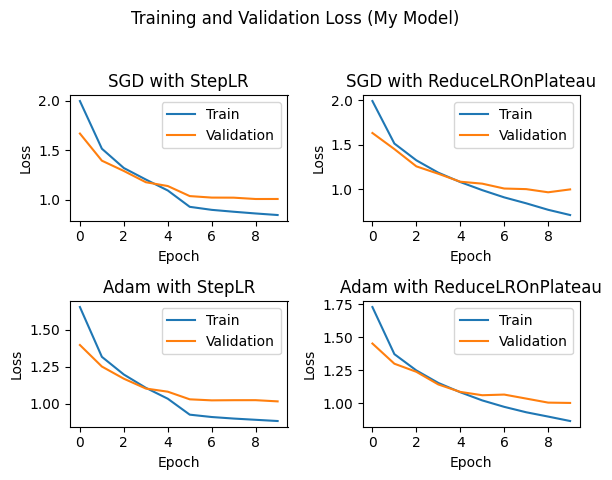

In [41]:
plot_metric_2x2(
    [
        train_history_sgd_step_lr,
        train_history_sgd_reduce_on_plateau,
        train_history_adam_step_lr,
        train_history_adam_reduce_on_plateau,
    ],
    "loss",
    "Training and Validation Loss (My Model)",
)

#### Training/Validation Loss discussion
- First obvious difference is `ReduceLROnPlateau` training/validation loss is smoother than `StepLR`, this is because `StepLR` reduce learning rate by `gamma=0.1` every `step_size=5` epoch as seen in the sharp corner of both training loss and validation loss at epoch 5
- Another difference is `Adam` Converges a little bit faster than `SGD` especially in the early epochs, this is because `Adam` has adaptive step sizes as it adjusts learning rate per parameter, making it faster to find minina, while `SGD` using the same global learning rate for every parameters and rely only on momentum to make the convergence smoother but slower.

#### Training/Validation Accuracy and F1-Score plots

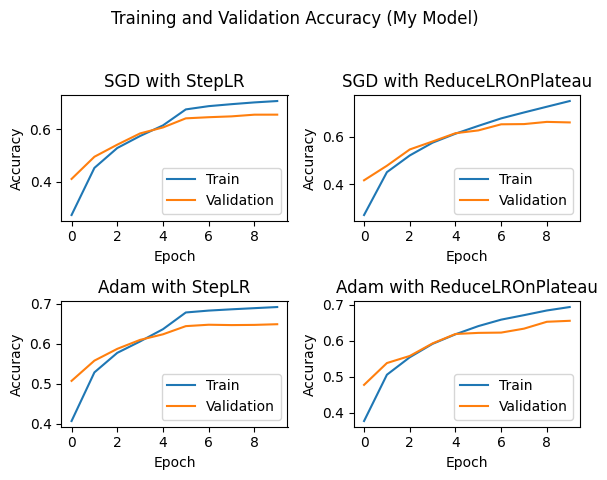

In [42]:
plot_metric_2x2(
    [
        train_history_sgd_step_lr,
        train_history_sgd_reduce_on_plateau,
        train_history_adam_step_lr,
        train_history_adam_reduce_on_plateau,
    ],
    "accuracy",
    "Training and Validation Accuracy (My Model)",
)

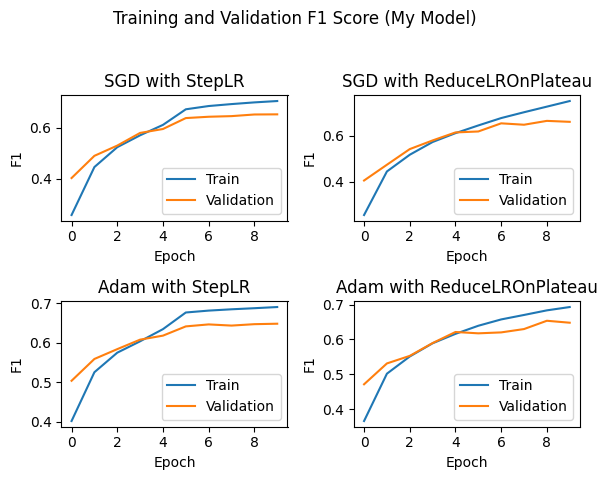

In [43]:
plot_metric_2x2(
    [
        train_history_sgd_step_lr,
        train_history_sgd_reduce_on_plateau,
        train_history_adam_step_lr,
        train_history_adam_reduce_on_plateau,
    ],
    "f1",
    "Training and Validation F1 Score (My Model)",
)

#### Training/Validation Accuracy and F1-Score discussion
These score are just inverse of loss in which higher is better. It's not really useful to use them in training/validation but I want to include them anyway for completeness.

### Evaluation on Test Set

In [14]:
def evaluate_model(test_loader, model, device):
    # .eval() sets the model to evaluation mode
    # which turns off dropout and uses running stats for batchnorm
    # This is important for consistent evaluation
    # especially if the model uses layers like dropout or batchnorm
    # that behave differently during training and evaluation
    # For models without such layers, .eval() has no effect
    # but it's still good practice to include it for future compatibility
    # as the model architecture may change later
    model.eval()

    # Initialize test predictions and true labels lists
    # so classification report and confusion matrix can be computed
    test_predictions = []
    test_true_labels = []

    # Disable gradient calculation for evaluation
    # This reduces memory consumption and speeds up computation
    # as we don't need gradients for inference
    # otherwise, forward pass will generate backward graph for backpropagation
    # and store intermediate results for gradient calculation,
    # which is unnecessary during evaluation
    with torch.no_grad():
        # Iterate over the test dataset batch by batch
        for images, labels in test_loader:
            # Move images and labels to the correct device
            images, labels = images.to(device), labels.to(device)

            # Forward pass to get model predictions
            # This does not automatically create a backpropagation graph due to torch.no_grad()
            outputs = model(images)

            # Get the predicted class by finding the index with the maximum score
            # torch.max returns a tuple (max_value, max_index)
            # We only need the index, which corresponds to the predicted class
            _, predicted = torch.max(outputs.data, 1)

            # Store predictions and true labels for later evaluation
            test_predictions.extend(predicted.cpu().numpy())
            test_true_labels.extend(labels.cpu().numpy())

    # Print classification report and confusion matrix
    print("Classification Report:")
    print(
        classification_report(
            test_true_labels,
            test_predictions,
            target_names=test_loader.dataset.classes,
        )
    )
    print("Confusion Matrix:")
    cm = confusion_matrix(test_true_labels, test_predictions)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=test_loader.dataset.classes,
    )
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

#### Test Set Classification Report and Confusion Matrix

Classification Report:
              precision    recall  f1-score   support

    airplane       0.70      0.70      0.70      1000
  automobile       0.73      0.78      0.75      1000
        bird       0.55      0.53      0.54      1000
         cat       0.49      0.46      0.47      1000
        deer       0.63      0.57      0.60      1000
         dog       0.57      0.55      0.56      1000
        frog       0.74      0.71      0.73      1000
       horse       0.71      0.71      0.71      1000
        ship       0.71      0.81      0.76      1000
       truck       0.69      0.72      0.71      1000

    accuracy                           0.65     10000
   macro avg       0.65      0.65      0.65     10000
weighted avg       0.65      0.65      0.65     10000

Confusion Matrix:


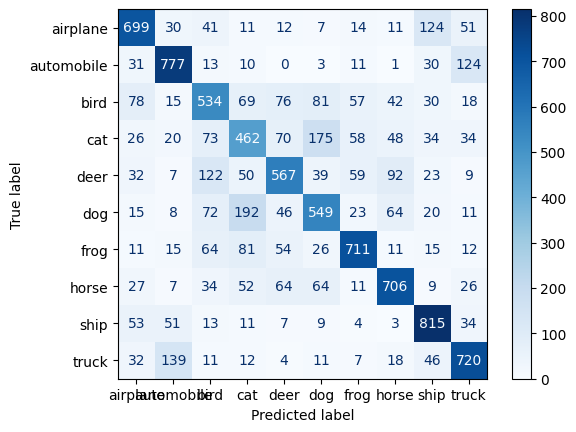

In [15]:
evaluate_model(test_loader, my_model_1, device)

Classification Report:
              precision    recall  f1-score   support

    airplane       0.68      0.71      0.69      1000
  automobile       0.76      0.77      0.76      1000
        bird       0.64      0.48      0.55      1000
         cat       0.44      0.52      0.47      1000
        deer       0.73      0.47      0.57      1000
         dog       0.51      0.64      0.57      1000
        frog       0.72      0.75      0.74      1000
       horse       0.76      0.70      0.73      1000
        ship       0.68      0.88      0.77      1000
       truck       0.78      0.68      0.72      1000

    accuracy                           0.66     10000
   macro avg       0.67      0.66      0.66     10000
weighted avg       0.67      0.66      0.66     10000

Confusion Matrix:


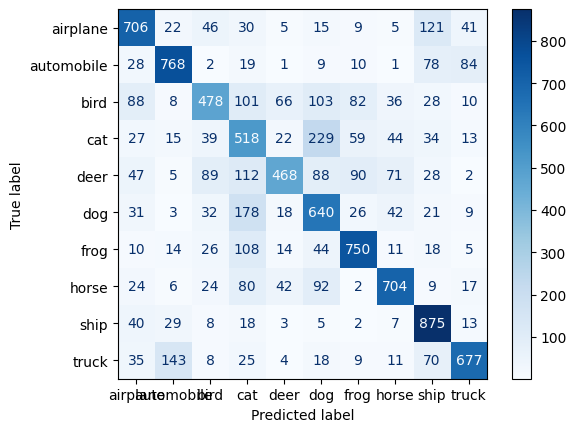

In [16]:
evaluate_model(test_loader, my_model_2, device)

Classification Report:
              precision    recall  f1-score   support

    airplane       0.67      0.75      0.71      1000
  automobile       0.79      0.72      0.75      1000
        bird       0.54      0.52      0.53      1000
         cat       0.48      0.45      0.46      1000
        deer       0.61      0.60      0.60      1000
         dog       0.55      0.59      0.57      1000
        frog       0.74      0.72      0.73      1000
       horse       0.71      0.72      0.71      1000
        ship       0.75      0.78      0.77      1000
       truck       0.72      0.71      0.72      1000

    accuracy                           0.66     10000
   macro avg       0.66      0.66      0.66     10000
weighted avg       0.66      0.66      0.66     10000

Confusion Matrix:


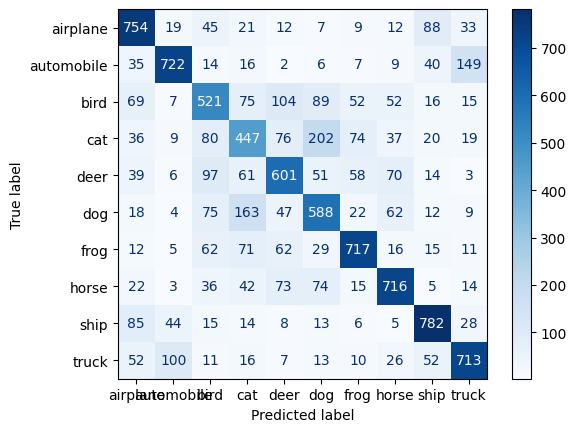

In [17]:
evaluate_model(test_loader, my_model_3, device)

Classification Report:
              precision    recall  f1-score   support

    airplane       0.64      0.80      0.71      1000
  automobile       0.74      0.82      0.78      1000
        bird       0.68      0.38      0.49      1000
         cat       0.50      0.47      0.48      1000
        deer       0.61      0.56      0.58      1000
         dog       0.64      0.45      0.53      1000
        frog       0.60      0.88      0.71      1000
       horse       0.66      0.78      0.71      1000
        ship       0.83      0.72      0.77      1000
       truck       0.72      0.72      0.72      1000

    accuracy                           0.66     10000
   macro avg       0.66      0.66      0.65     10000
weighted avg       0.66      0.66      0.65     10000

Confusion Matrix:


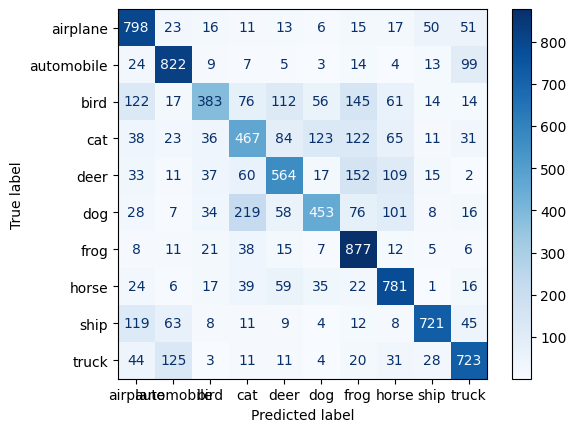

In [18]:
evaluate_model(test_loader, my_model_4, device)

#### Test Set Classification Report and Confusion Matrix discussion
- All the models perform fairly ok with accuracy and F1-score around 65-66% accuracy on the test set.
- Confusion matrices show that most of the models have trouble classifying between animals especially cat and dog classes, but understandable since they are visually similar. Another groups is airplane <-> ship and truck <-> automobile which are also visually similar.

### Misclassified Examples

In [36]:
# Misclassified examples
def plot_misclassified_examples(test_loader, model, device, num_examples=5):
    import torch.nn.functional as F

    model.eval()
    misclassified_images = []
    misclassified_labels = []
    misclassified_probs = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = F.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs.data, 1)
            # Find misclassified examples
            for i in range(len(labels)):
                if predicted[i] != labels[i]:
                    misclassified_images.append(images[i].cpu())
                    misclassified_labels.append((labels[i].cpu(), predicted[i].cpu()))
                    misclassified_probs.append(probs[i, predicted[i]].cpu().item())
                if len(misclassified_images) >= num_examples:
                    break
            if len(misclassified_images) >= num_examples:
                break
    # Plot misclassified examples
    plt.figure(figsize=(10, 5))
    for i in range(num_examples):
        img = misclassified_images[i]
        true_label, pred_label = misclassified_labels[i]
        prob = misclassified_probs[i]
        plt.subplot(1, num_examples, i + 1)
        plt.imshow(img.permute(1, 2, 0))
        plt.title(
            f"True: {test_loader.dataset.classes[true_label]}\nPred: {test_loader.dataset.classes[pred_label]}\nProb: {prob:.2f}"
        )
        plt.axis("off")
    plt.tight_layout()
    plt.show()


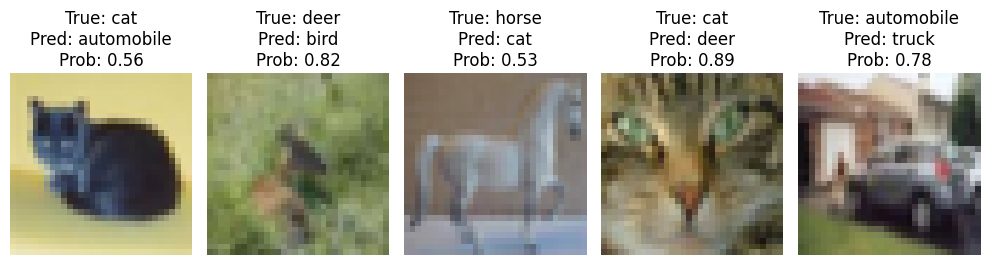

In [83]:
plot_misclassified_examples(test_loader, my_model_1, device, num_examples=5)

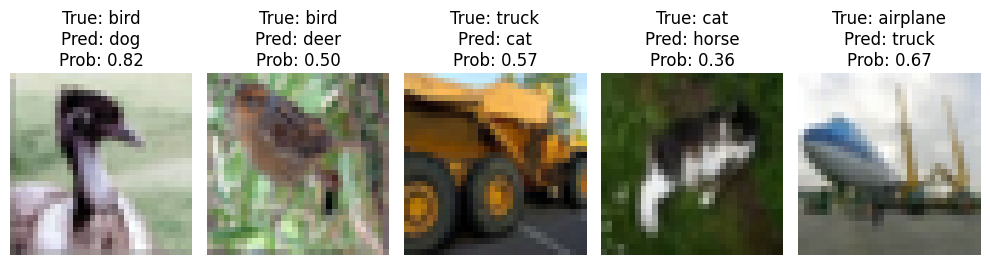

In [61]:
plot_misclassified_examples(test_loader, my_model_2, device, num_examples=5)

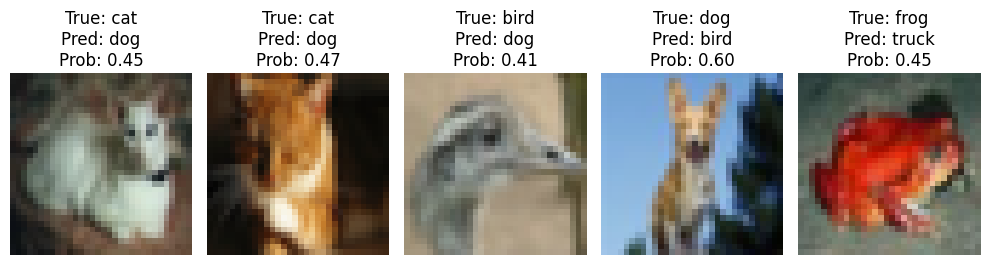

In [62]:
plot_misclassified_examples(test_loader, my_model_3, device, num_examples=5)

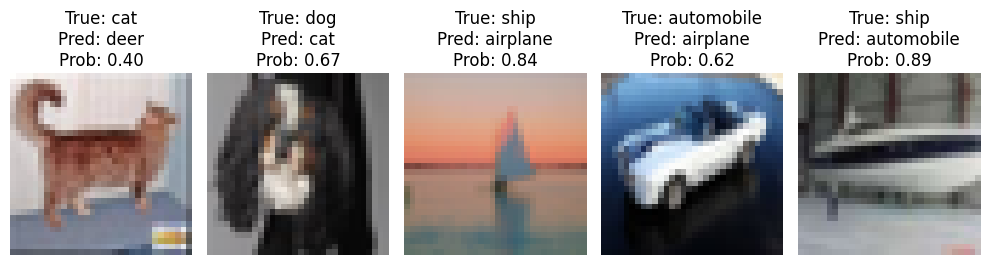

In [63]:
plot_misclassified_examples(test_loader, my_model_4, device, num_examples=5)

#### Misclassified Examples discussion
- Most of the misclassified examples are visually ambiguous even for human to classify
- The 2nd image of the 1st model is a deer laying on the grass, but the model predicted bird which is reasonable because it can be interpret as a bird standing on the wood stump with grass as background and also bird images usually have a lot of green trees/grass in the background.
- The 3rd image of the 4th model is a ship at sea with a lot of white water and orange sky, which the model predicted airplane, probably because the white water and orange sky can be interpreted as clouds and sky background of an airplane image.
- A lot of cat and dog images are misclassified as each other because they are visually similar.

### Activation Maps

In [123]:
# - Example activation maps from CNN layer1 and layer2
def plot_activation_maps(model, image):
    image_tensor = image.unsqueeze(0)  # Add batch dimension
    model.eval()
    with torch.no_grad():
        # Add batch dimension if needed
        if image_tensor.dim() == 3:
            image_tensor = image_tensor.unsqueeze(0)
        image_tensor = image_tensor.to(next(model.parameters()).device)

        # Forward pass up to conv1 and conv2
        x1 = model.relu(model.conv1(image_tensor))
        x1_pooled = model.pool(x1)
        x2 = model.relu(model.conv2(x1_pooled))

        # Plot original image
        plt.figure(figsize=(3, 3))
        plt.imshow(image.permute(1, 2, 0))
        plt.title("Original Image")
        plt.show()

        # Plot first 8 activation maps from conv1
        plt.figure(figsize=(12, 3))
        for i in range(8):
            plt.subplot(2, 8, i + 1)
            plt.imshow(x1[0, i].cpu().numpy(), cmap="viridis")
            plt.title(f"conv1[{i}]")
            plt.axis("off")

        # Plot first 8 activation maps from conv2
        for i in range(8):
            plt.subplot(2, 8, 8 + i + 1)
            plt.imshow(x2[0, i].cpu().numpy(), cmap="viridis")
            plt.title(f"conv2[{i}]")
            plt.axis("off")

        plt.tight_layout()
        plt.show()

In [111]:
sample_img, _ = cifar10_test[1]

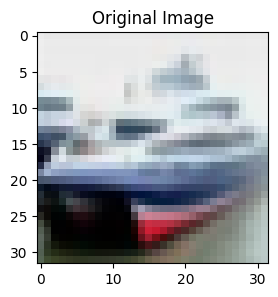

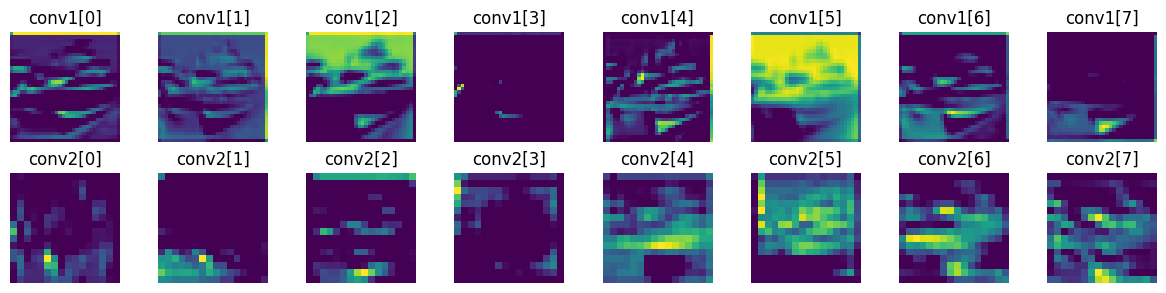

In [124]:
plot_activation_maps(my_model_1, sample_img)

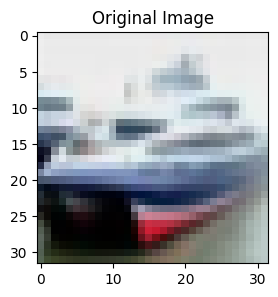

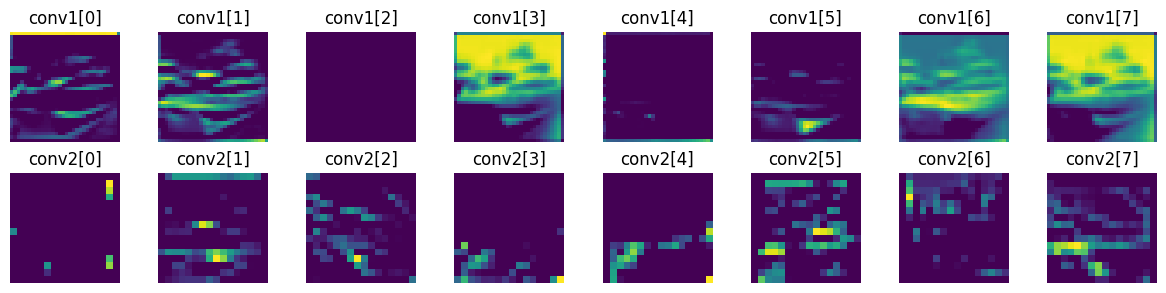

In [125]:
plot_activation_maps(my_model_2, sample_img)

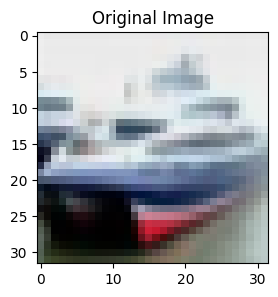

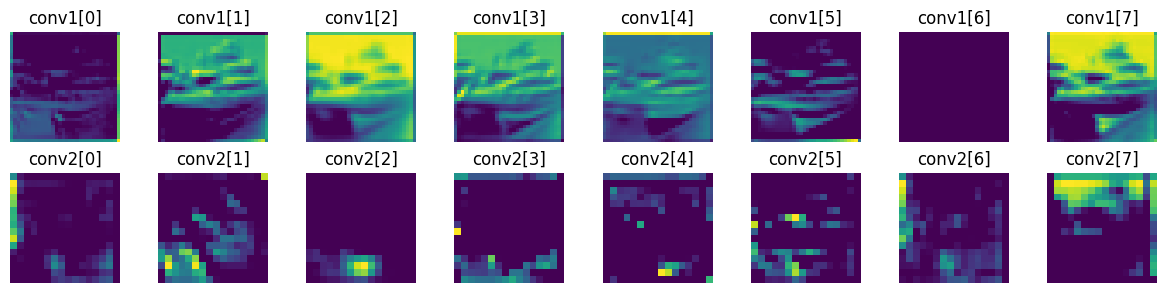

In [126]:
plot_activation_maps(my_model_3, sample_img)

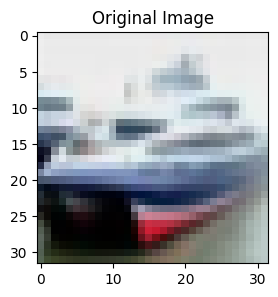

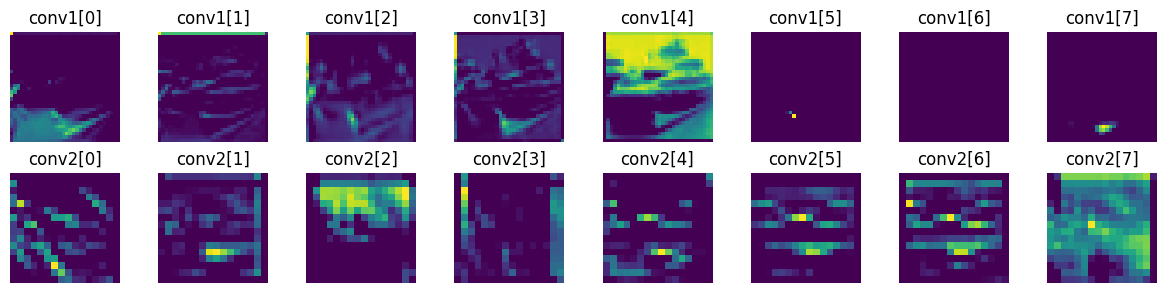

In [127]:
plot_activation_maps(my_model_4, sample_img)

#### Activation Maps discussion
- The activation maps shows that the model is able to focus on the important features of the objects in the image, such as the shape and texture. For example, in the conv1 layer, the ship shape is still mostly intact in all models, then in the conv2, the feature maps are now more abstract and can't really be intepreted visually anymore.

# Part 2 - ResNet Model

## Experiment Preparation

In [89]:
resnet_1 = torchvision.models.resnet18(weights=False, num_classes=10)
resnet_2 = torchvision.models.resnet18(weights=False, num_classes=10)
resnet_3 = torchvision.models.resnet18(weights=False, num_classes=10)
resnet_4 = torchvision.models.resnet18(weights=False, num_classes=10)
resnet_1.to(device)
resnet_2.to(device)
resnet_3.to(device)
resnet_4.to(device)
print("ResNet18 Model summaries and trainable parameters:")
print("==================== ResNet 1 ====================")
print(resnet_1)
print("==================== ResNet 2 ====================")
print(resnet_2)
print("==================== ResNet 3 ====================")
print(resnet_3)
print("==================== ResNet 4 ====================")
print(resnet_4)

criterion = torch.nn.CrossEntropyLoss()
optimizer_sgd_1_resnet = torch.optim.SGD(resnet_1.parameters(), lr=0.01, momentum=0.9)
scheduler_step_lr_1_resnet = torch.optim.lr_scheduler.StepLR(optimizer_sgd_1_resnet, step_size=5, gamma=0.1)
optimizer_sgd_2_resnet = torch.optim.SGD(resnet_2.parameters(), lr=0.01, momentum=0.9)
scheduler_reduce_on_plateau_1_resnet = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_sgd_2_resnet, mode="min", factor=0.1, patience=3
)
optimizer_adam_1_resnet = torch.optim.Adam(resnet_3.parameters(), lr=0.001)
scheduler_step_lr_2_resnet = torch.optim.lr_scheduler.StepLR(optimizer_adam_1_resnet, step_size=5, gamma=0.1)
optimizer_adam_2_resnet = torch.optim.Adam(resnet_4.parameters(), lr=0.001)
scheduler_reduce_on_plateau_2_resnet = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_adam_2_resnet, mode="min", factor=0.1, patience=3
)
num_epochs = 10

z:\AT82.08-CV-A2\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet18 Model summaries and trainable parameters:
==================== ResNet 1 ====================
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(6

## Start Training ResNet model

In [90]:
train_history_sgd_step_lr_resnet = train_model(
    train_loader,
    val_loader,
    resnet_1,
    criterion,
    optimizer_sgd_1_resnet,
    scheduler_step_lr_1_resnet,
    num_epochs,
    device,
)

Epoch [1/10], Loss: 1.5987, Val Loss: 1.4359, Val Acc: 0.4915, Val F1: 0.4782
Epoch [2/10], Loss: 1.2026, Val Loss: 1.4596, Val Acc: 0.4861, Val F1: 0.4986
Epoch [3/10], Loss: 0.9915, Val Loss: 1.0481, Val Acc: 0.6342, Val F1: 0.6333
Epoch [4/10], Loss: 0.8352, Val Loss: 1.0527, Val Acc: 0.6387, Val F1: 0.6349
Epoch [5/10], Loss: 0.6965, Val Loss: 1.1085, Val Acc: 0.6342, Val F1: 0.6259
Epoch [6/10], Loss: 0.3944, Val Loss: 0.8841, Val Acc: 0.7201, Val F1: 0.7212
Epoch [7/10], Loss: 0.2898, Val Loss: 0.9420, Val Acc: 0.7188, Val F1: 0.7190
Epoch [8/10], Loss: 0.2237, Val Loss: 1.0069, Val Acc: 0.7158, Val F1: 0.7175
Epoch [9/10], Loss: 0.1655, Val Loss: 1.1313, Val Acc: 0.7104, Val F1: 0.7090
Epoch [10/10], Loss: 0.1194, Val Loss: 1.2604, Val Acc: 0.7094, Val F1: 0.7112


In [91]:
train_history_sgd_reduce_on_plateau_resnet = train_model(
    train_loader,
    val_loader,
    resnet_2,
    criterion,
    optimizer_sgd_2_resnet,
    scheduler_reduce_on_plateau_1_resnet,
    num_epochs,
    device,
)

Epoch [1/10], Loss: 1.6190, Val Loss: 1.9580, Val Acc: 0.4653, Val F1: 0.4543
Epoch [2/10], Loss: 1.2157, Val Loss: 1.1994, Val Acc: 0.5854, Val F1: 0.5791
Epoch [3/10], Loss: 0.9983, Val Loss: 1.1343, Val Acc: 0.6105, Val F1: 0.6016
Epoch [4/10], Loss: 0.8282, Val Loss: 1.0931, Val Acc: 0.6293, Val F1: 0.6293
Epoch [5/10], Loss: 0.6981, Val Loss: 1.0115, Val Acc: 0.6559, Val F1: 0.6622
Epoch [6/10], Loss: 0.5839, Val Loss: 1.1376, Val Acc: 0.6316, Val F1: 0.6286
Epoch [7/10], Loss: 0.4722, Val Loss: 1.0383, Val Acc: 0.6745, Val F1: 0.6765
Epoch [8/10], Loss: 0.3940, Val Loss: 1.2581, Val Acc: 0.6421, Val F1: 0.6494
Epoch [9/10], Loss: 0.3323, Val Loss: 1.3465, Val Acc: 0.6250, Val F1: 0.6330
Epoch [10/10], Loss: 0.1224, Val Loss: 1.0292, Val Acc: 0.7337, Val F1: 0.7338


In [92]:
train_history_adam_step_lr_resnet = train_model(
    train_loader,
    val_loader,
    resnet_3,
    criterion,
    optimizer_adam_1_resnet,
    scheduler_step_lr_2_resnet,
    num_epochs,
    device,
)

Epoch [1/10], Loss: 1.4355, Val Loss: 1.3130, Val Acc: 0.5343, Val F1: 0.5344
Epoch [2/10], Loss: 1.0561, Val Loss: 1.4016, Val Acc: 0.5350, Val F1: 0.5365
Epoch [3/10], Loss: 0.8790, Val Loss: 1.0822, Val Acc: 0.6170, Val F1: 0.6084
Epoch [4/10], Loss: 0.7439, Val Loss: 0.9322, Val Acc: 0.6834, Val F1: 0.6805
Epoch [5/10], Loss: 0.6285, Val Loss: 1.0875, Val Acc: 0.6427, Val F1: 0.6374
Epoch [6/10], Loss: 0.3537, Val Loss: 0.7065, Val Acc: 0.7632, Val F1: 0.7643
Epoch [7/10], Loss: 0.2549, Val Loss: 0.7577, Val Acc: 0.7640, Val F1: 0.7651
Epoch [8/10], Loss: 0.1879, Val Loss: 0.8314, Val Acc: 0.7619, Val F1: 0.7616
Epoch [9/10], Loss: 0.1343, Val Loss: 0.9344, Val Acc: 0.7543, Val F1: 0.7541
Epoch [10/10], Loss: 0.0886, Val Loss: 1.0666, Val Acc: 0.7522, Val F1: 0.7552


In [93]:
train_history_adam_reduce_on_plateau_resnet = train_model(
    train_loader,
    val_loader,
    resnet_4,
    criterion,
    optimizer_adam_2_resnet,
    scheduler_reduce_on_plateau_2_resnet,
    num_epochs,
    device,
)

Epoch [1/10], Loss: 1.4359, Val Loss: 1.5425, Val Acc: 0.4709, Val F1: 0.4470
Epoch [2/10], Loss: 1.0535, Val Loss: 1.2070, Val Acc: 0.5838, Val F1: 0.5780
Epoch [3/10], Loss: 0.8653, Val Loss: 1.0400, Val Acc: 0.6369, Val F1: 0.6274
Epoch [4/10], Loss: 0.7400, Val Loss: 0.9531, Val Acc: 0.6769, Val F1: 0.6801
Epoch [5/10], Loss: 0.6297, Val Loss: 0.9175, Val Acc: 0.6920, Val F1: 0.6903
Epoch [6/10], Loss: 0.5427, Val Loss: 0.9588, Val Acc: 0.6885, Val F1: 0.6875
Epoch [7/10], Loss: 0.4450, Val Loss: 1.1425, Val Acc: 0.6667, Val F1: 0.6525
Epoch [8/10], Loss: 0.3678, Val Loss: 0.9540, Val Acc: 0.7066, Val F1: 0.7030
Epoch [9/10], Loss: 0.3092, Val Loss: 0.9209, Val Acc: 0.7259, Val F1: 0.7276
Epoch [10/10], Loss: 0.1168, Val Loss: 0.8115, Val Acc: 0.7792, Val F1: 0.7796


## Save training history and models

In [96]:
save_training_history(
    train_history_sgd_step_lr_resnet,
    "task1_models/train_history_sgd_step_lr_resnet.json",
)
save_training_history(
    train_history_sgd_reduce_on_plateau_resnet,
    "task1_models/train_history_sgd_reduce_on_plateau_resnet.json",
)
save_training_history(
    train_history_adam_step_lr_resnet,
    "task1_models/train_history_adam_step_lr_resnet.json",
)
save_training_history(
    train_history_adam_reduce_on_plateau_resnet,
    "task1_models/train_history_adam_reduce_on_plateau_resnet.json",
)

In [97]:
torch.save(resnet_1.state_dict(), "task1_models/resnet_sgd_step_lr.pth")
torch.save(resnet_2.state_dict(), "task1_models/resnet_sgd_reduce_on_plateau.pth")
torch.save(resnet_3.state_dict(), "task1_models/resnet_adam_step_lr.pth")
torch.save(resnet_4.state_dict(), "task1_models/resnet_adam_reduce_on_plateau.pth")

In [23]:
# Try loading the ResNet models back and putting them on the correct device
resnet_1 = torchvision.models.resnet18(weights=False, num_classes=10)
resnet_2 = torchvision.models.resnet18(weights=False, num_classes=10)
resnet_3 = torchvision.models.resnet18(weights=False, num_classes=10)
resnet_4 = torchvision.models.resnet18(weights=False, num_classes=10)
resnet_1.load_state_dict(torch.load("task1_models/resnet_sgd_step_lr.pth"))
resnet_2.load_state_dict(torch.load("task1_models/resnet_sgd_reduce_on_plateau.pth"))
resnet_3.load_state_dict(torch.load("task1_models/resnet_adam_step_lr.pth"))
resnet_4.load_state_dict(torch.load("task1_models/resnet_adam_reduce_on_plateau.pth"))
resnet_1.to(device)
resnet_2.to(device)
resnet_3.to(device)
resnet_4.to(device)

d:\AT82.08-CV-A2\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Evaluation and Analysis of ResNet model

### Plotting Training/Validation Metrics

#### Training/Validation Loss plots

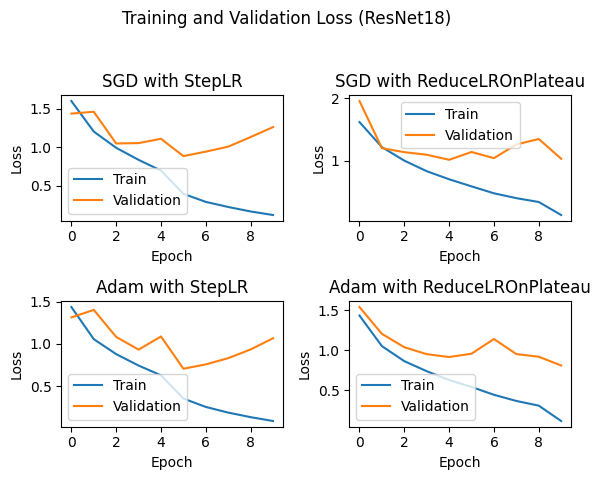

In [99]:
plot_metric_2x2(
    [
        train_history_sgd_step_lr_resnet,
        train_history_sgd_reduce_on_plateau_resnet,
        train_history_adam_step_lr_resnet,
        train_history_adam_reduce_on_plateau_resnet,
    ],
    "loss",
    "Training and Validation Loss (ResNet18)",
)

#### Training/Validation Loss discussion
- Even though the validation loss looks a bit choppy, the ResNet model converges faster and to a lower loss value than my model. This is probably because ResNet architecture is more advanced and deeper than my model, so it can learn more complex features from the data.
- `StepLR` learning rate scheduler still shows the sharp corner at epoch 5 as in my model, while `ReduceLROnPlateau` is still smoother.
- `Adam` optimizer still converges faster than `SGD` as in my model.
- But my models converge to just below 1.0 loss value, while ResNet models converge all the way down to around 0.1 loss value, which is a significant improvement but may also indicate overfitting as the validation loss start to fluctuate after training loss below 1.0

#### Training/Validation Accuracy and F1-Score plots

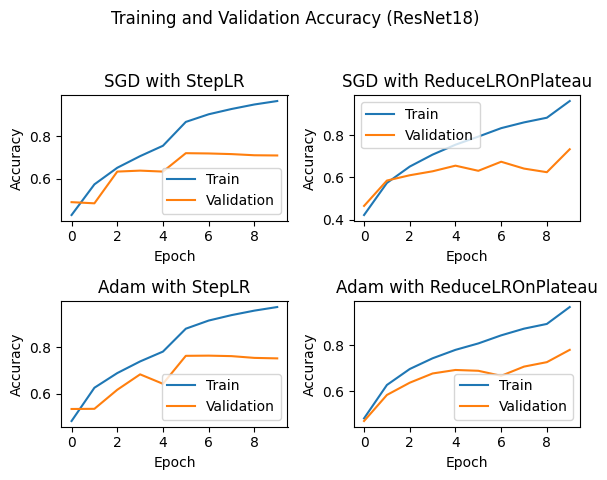

In [100]:
plot_metric_2x2(
    [
        train_history_sgd_step_lr_resnet,
        train_history_sgd_reduce_on_plateau_resnet,
        train_history_adam_step_lr_resnet,
        train_history_adam_reduce_on_plateau_resnet,
    ],
    "accuracy",
    "Training and Validation Accuracy (ResNet18)",
)

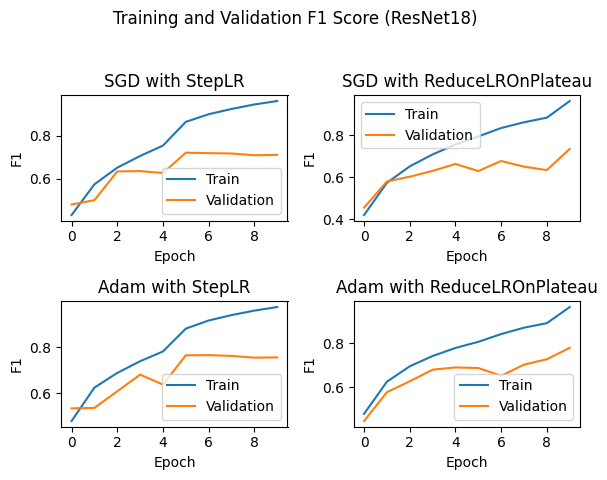

In [101]:
plot_metric_2x2(
    [
        train_history_sgd_step_lr_resnet,
        train_history_sgd_reduce_on_plateau_resnet,
        train_history_adam_step_lr_resnet,
        train_history_adam_reduce_on_plateau_resnet,
    ],
    "f1",
    "Training and Validation F1 Score (ResNet18)",
)

#### Training/Validation Accuracy and F1-Score discussion
- The accuracy and F1-score plots also show that ResNet models achieve higher scores than my models, reaching well above 90% training accuracy.
- In validation accuracy and F1-score, `StepLR` seems to stay flat after epoch 5 while `ReduceLROnPlateau` stump a little bit but continue to improve a bit more, indicating that `StepLR` may have reduced the learning rate too much at epoch 5, making the model just more overfit to the training data without learning to generalize better, making validation score stagnant.

### Evaluation on Test Set

#### Classification Report and Confusion Matrix

Classification Report:
              precision    recall  f1-score   support

    airplane       0.75      0.76      0.75      1000
  automobile       0.81      0.79      0.80      1000
        bird       0.66      0.60      0.63      1000
         cat       0.51      0.55      0.53      1000
        deer       0.63      0.67      0.65      1000
         dog       0.59      0.62      0.61      1000
        frog       0.74      0.80      0.77      1000
       horse       0.77      0.74      0.76      1000
        ship       0.88      0.78      0.83      1000
       truck       0.78      0.76      0.77      1000

    accuracy                           0.71     10000
   macro avg       0.71      0.71      0.71     10000
weighted avg       0.71      0.71      0.71     10000

Confusion Matrix:


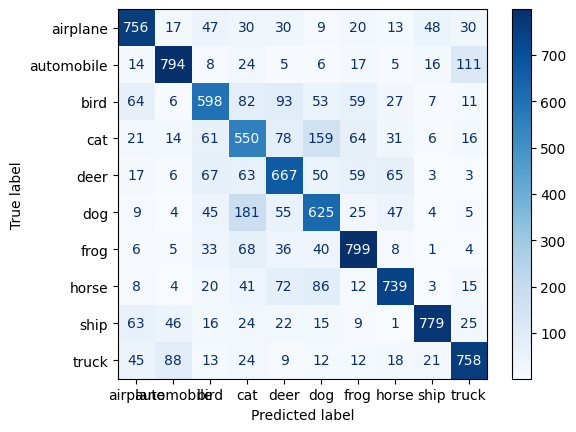

In [24]:
evaluate_model(test_loader, resnet_1, device)

Classification Report:
              precision    recall  f1-score   support

    airplane       0.74      0.78      0.76      1000
  automobile       0.84      0.82      0.83      1000
        bird       0.68      0.65      0.66      1000
         cat       0.54      0.54      0.54      1000
        deer       0.69      0.66      0.68      1000
         dog       0.62      0.62      0.62      1000
        frog       0.80      0.81      0.81      1000
       horse       0.77      0.79      0.78      1000
        ship       0.84      0.84      0.84      1000
       truck       0.79      0.80      0.79      1000

    accuracy                           0.73     10000
   macro avg       0.73      0.73      0.73     10000
weighted avg       0.73      0.73      0.73     10000

Confusion Matrix:


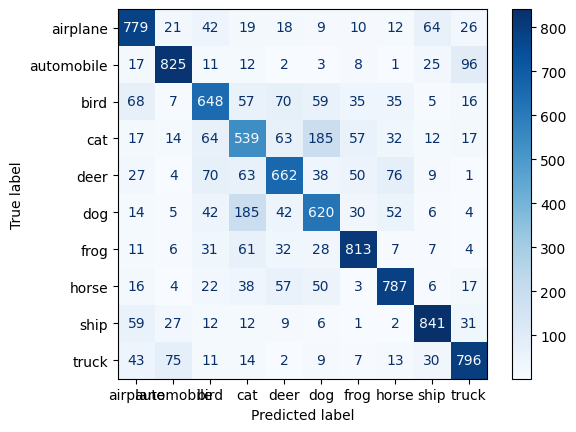

In [25]:
evaluate_model(test_loader, resnet_2, device)

Classification Report:
              precision    recall  f1-score   support

    airplane       0.79      0.79      0.79      1000
  automobile       0.83      0.85      0.84      1000
        bird       0.68      0.67      0.68      1000
         cat       0.51      0.66      0.58      1000
        deer       0.74      0.69      0.72      1000
         dog       0.64      0.60      0.62      1000
        frog       0.80      0.80      0.80      1000
       horse       0.83      0.77      0.80      1000
        ship       0.88      0.83      0.85      1000
       truck       0.82      0.81      0.81      1000

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000

Confusion Matrix:


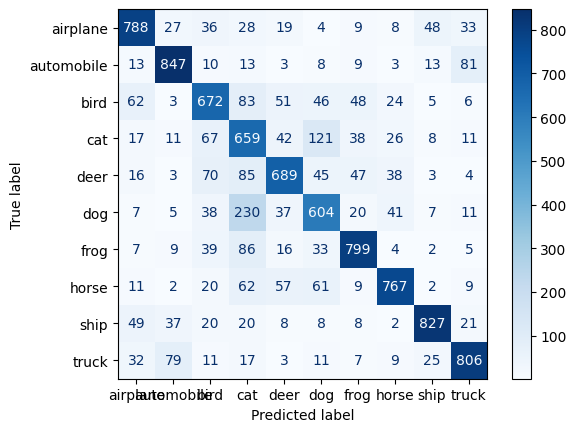

In [26]:
evaluate_model(test_loader, resnet_3, device)

Classification Report:
              precision    recall  f1-score   support

    airplane       0.80      0.82      0.81      1000
  automobile       0.87      0.84      0.85      1000
        bird       0.71      0.68      0.69      1000
         cat       0.58      0.61      0.60      1000
        deer       0.73      0.74      0.73      1000
         dog       0.67      0.64      0.66      1000
        frog       0.83      0.83      0.83      1000
       horse       0.81      0.82      0.82      1000
        ship       0.88      0.87      0.87      1000
       truck       0.83      0.83      0.83      1000

    accuracy                           0.77     10000
   macro avg       0.77      0.77      0.77     10000
weighted avg       0.77      0.77      0.77     10000

Confusion Matrix:


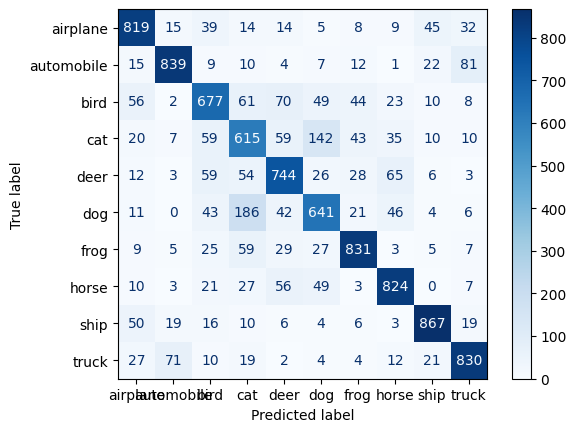

In [27]:
evaluate_model(test_loader, resnet_4, device)

#### Test Set Classification Report and Confusion Matrix discussion
- ResNet models perform significantly better than my models with 71-77% accuracy and F1-score on the test set.
- Confusion matrices show that the ResNet models are better at distinguishing between similar classes such as airplane and ship, truck and automobile, although cat and dog classes are still confused with each other the most.

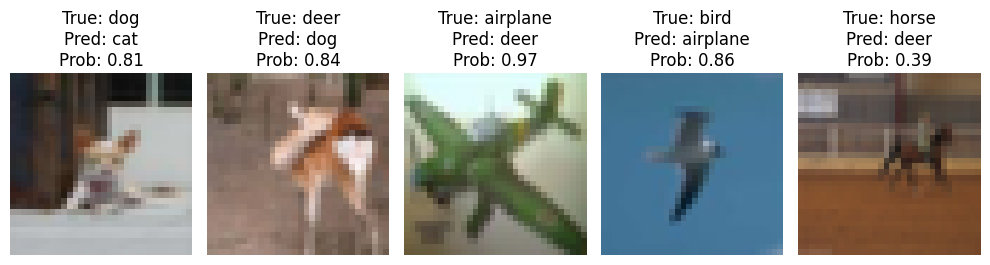

In [84]:
plot_misclassified_examples(test_loader, resnet_1, device, num_examples=5)

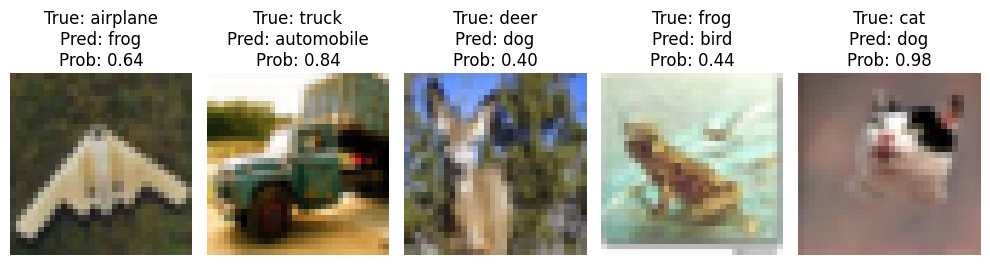

In [85]:
plot_misclassified_examples(test_loader, resnet_2, device, num_examples=5)

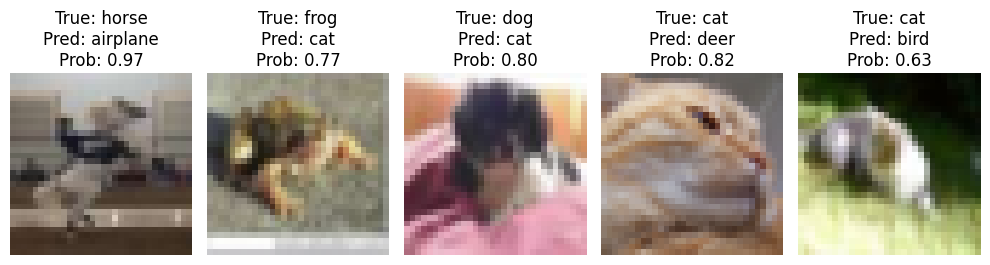

In [86]:
plot_misclassified_examples(test_loader, resnet_3, device, num_examples=5)

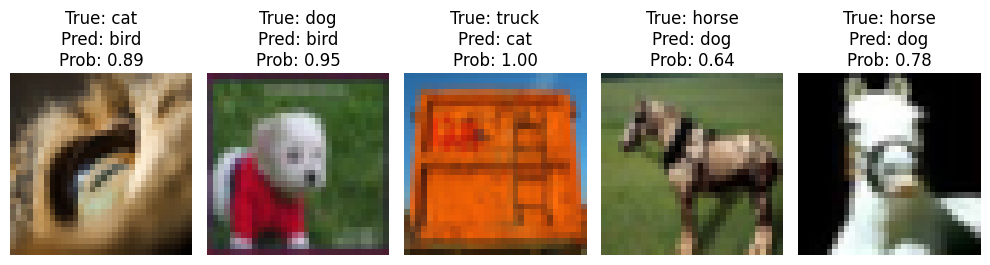

In [109]:
plot_misclassified_examples(test_loader, resnet_4, device, num_examples=5)

#### Misclassified Examples discussion
- Some of the misclassified examples are still visually ambiguous like animals being confused with each other, which is understandable.
- But ResNet models do show some form of overfitting problem as some of the misclassified examples are quite clear to be classified correctly, such as the 3rd image of the 1st model which is clearly an airplane with green color but the model predicted deer with very high softmax probability, which is quite far off.
- The 3rd image of the 4th model is a back view of a truck with orange color, but the model predicted cat with 1.0 softmax probability, which is very far off, but still, the 4th model get the best accuracy and F1-score on the test set among all models.

### Activation Maps

In [150]:
def plot_activation_maps_resnet(model, image):
    model.eval()

    # Add batch dimension if missing
    if image.dim() == 3:
        image_tensor = image.unsqueeze(0)
    else:
        image_tensor = image

    # Move image to same device as model
    image_tensor = image_tensor.to(next(model.parameters()).device)

    with torch.no_grad():
        # Forward pass
        # I'm not sure if layer1 and layer2 are the correct layers to visualize
        # so I plot 3 layers: conv1, layer1, and layer2
        x_conv1 = model.relu(model.bn1(model.conv1(image_tensor)))
        x_conv1_pooled = model.maxpool(x_conv1)
        x_layer1 = model.layer1(x_conv1_pooled)
        x_layer2 = model.layer2(x_layer1)

    fig = plt.figure(figsize=(16, 6))

    # Row 1: conv1
    for i in range(8):
        ax = fig.add_subplot(3, 8, i + 1)
        ax.imshow(x_conv1[0, i].cpu(), cmap="viridis")
        ax.set_title(f"conv1[{i}]")
        ax.axis("off")

    # Row 2: layer1
    for i in range(8):
        ax = fig.add_subplot(3, 8, 8 + i + 1)
        ax.imshow(x_layer1[0, i].cpu(), cmap="viridis")
        ax.set_title(f"layer1[{i}]")
        ax.axis("off")

    # Row 3: layer2
    for i in range(8):
        ax = fig.add_subplot(3, 8, 16 + i + 1)
        ax.imshow(x_layer2[0, i].cpu(), cmap="viridis")
        ax.set_title(f"layer2[{i}]")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

In [151]:
sample_img, _ = cifar10_test[1]

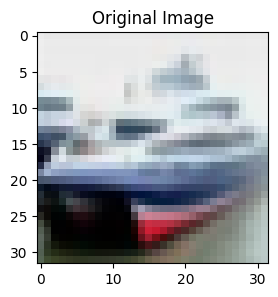

In [156]:
# plot original image
plt.figure(figsize=(3, 3))
plt.imshow(sample_img.permute(1, 2, 0))
plt.title("Original Image")
plt.show()

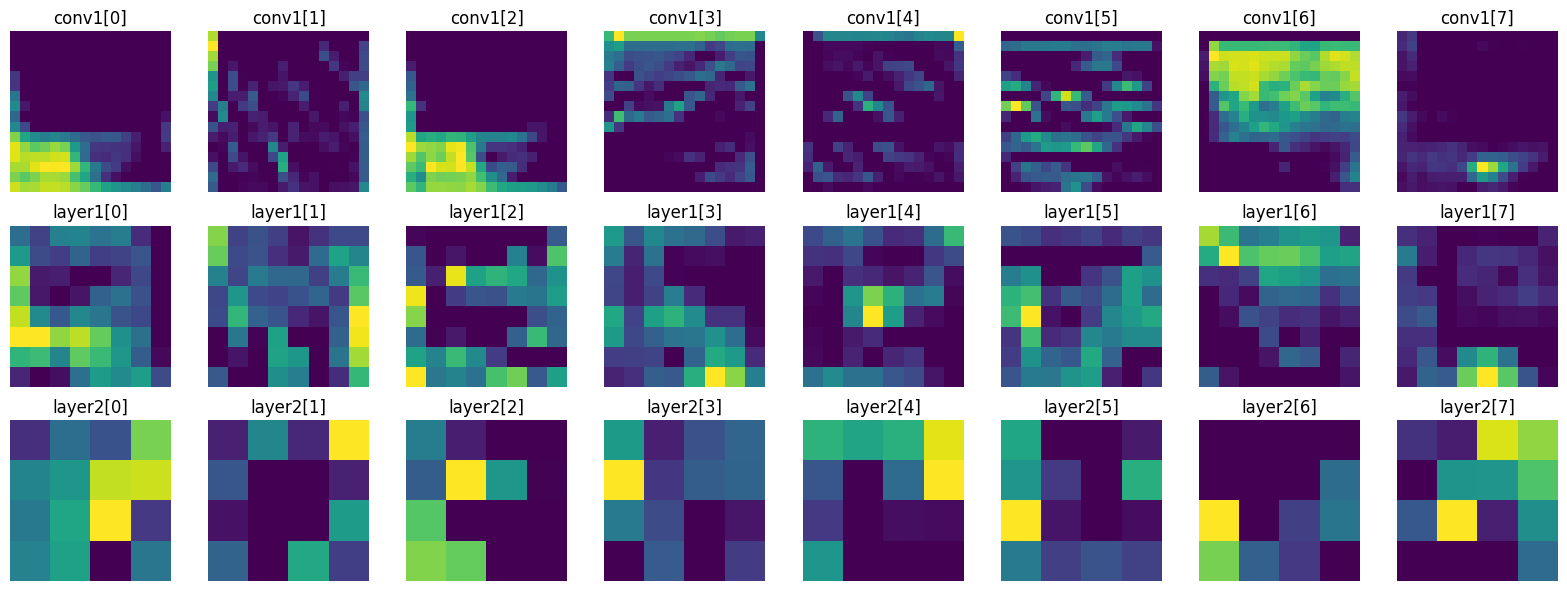

In [152]:
plot_activation_maps_resnet(resnet_1, sample_img)

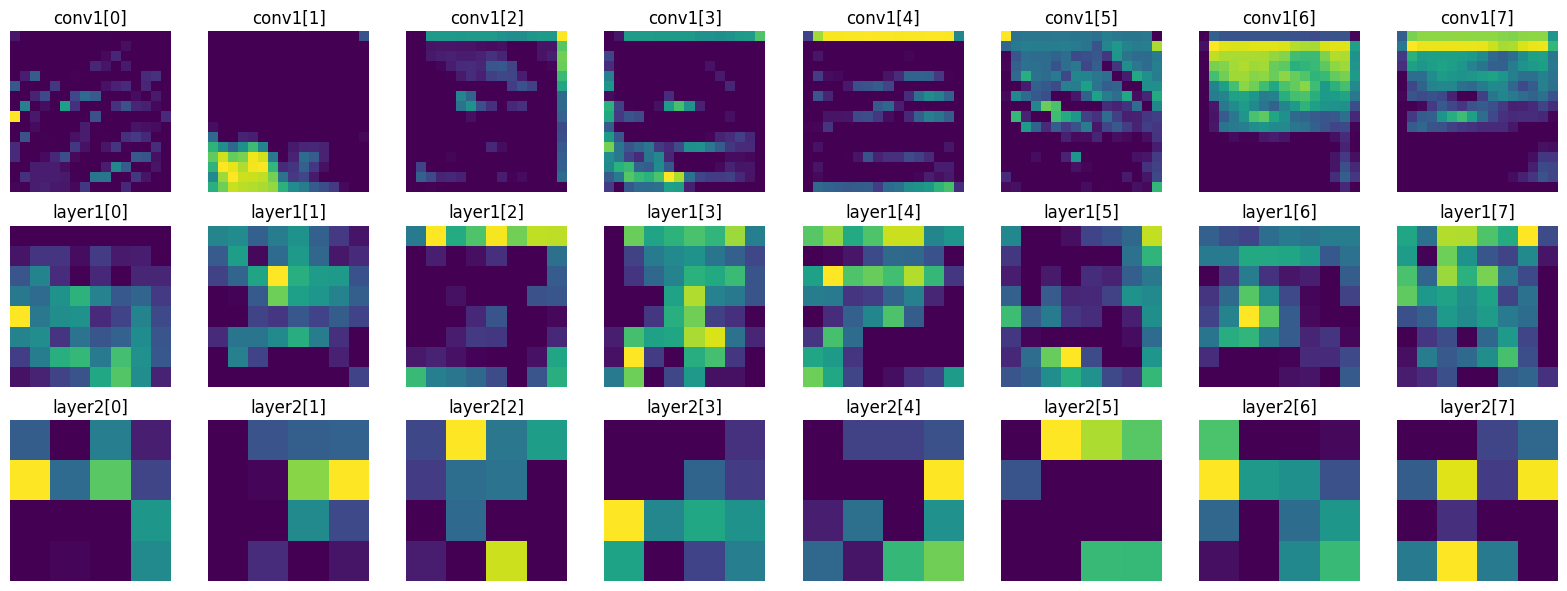

In [153]:
plot_activation_maps_resnet(resnet_2, sample_img)

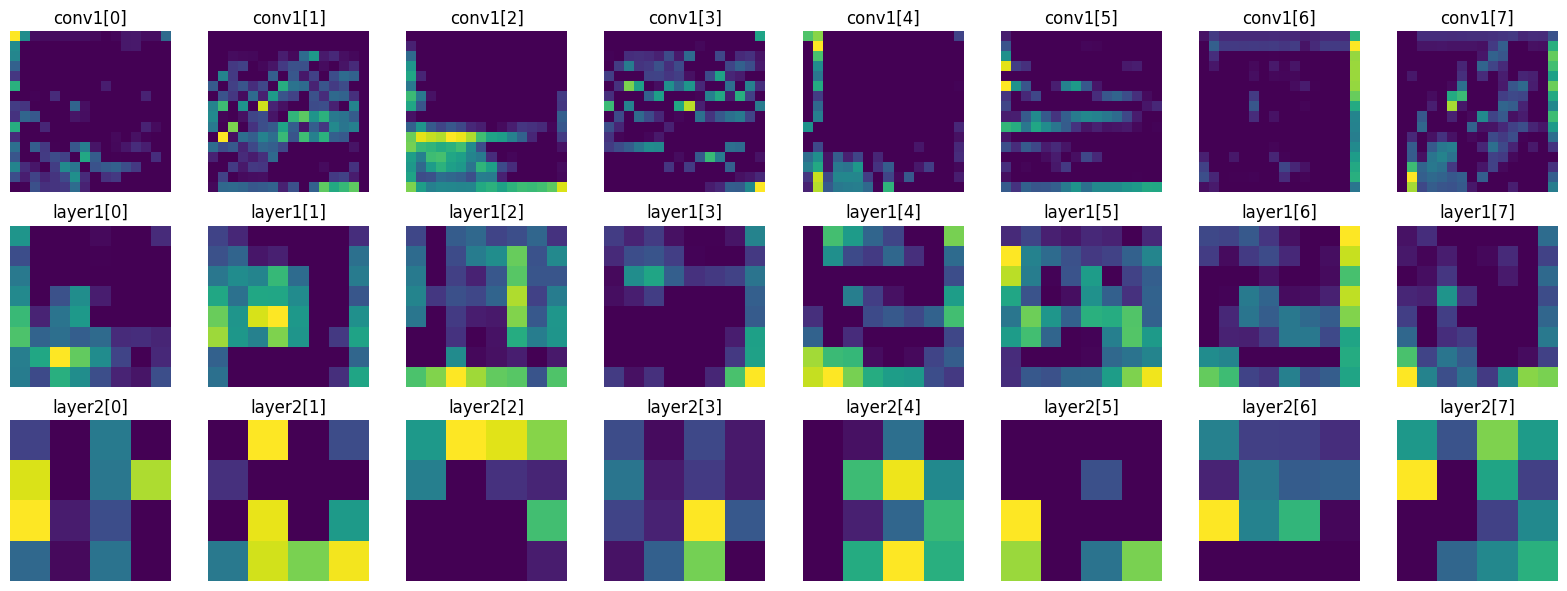

In [154]:
plot_activation_maps_resnet(resnet_3, sample_img)

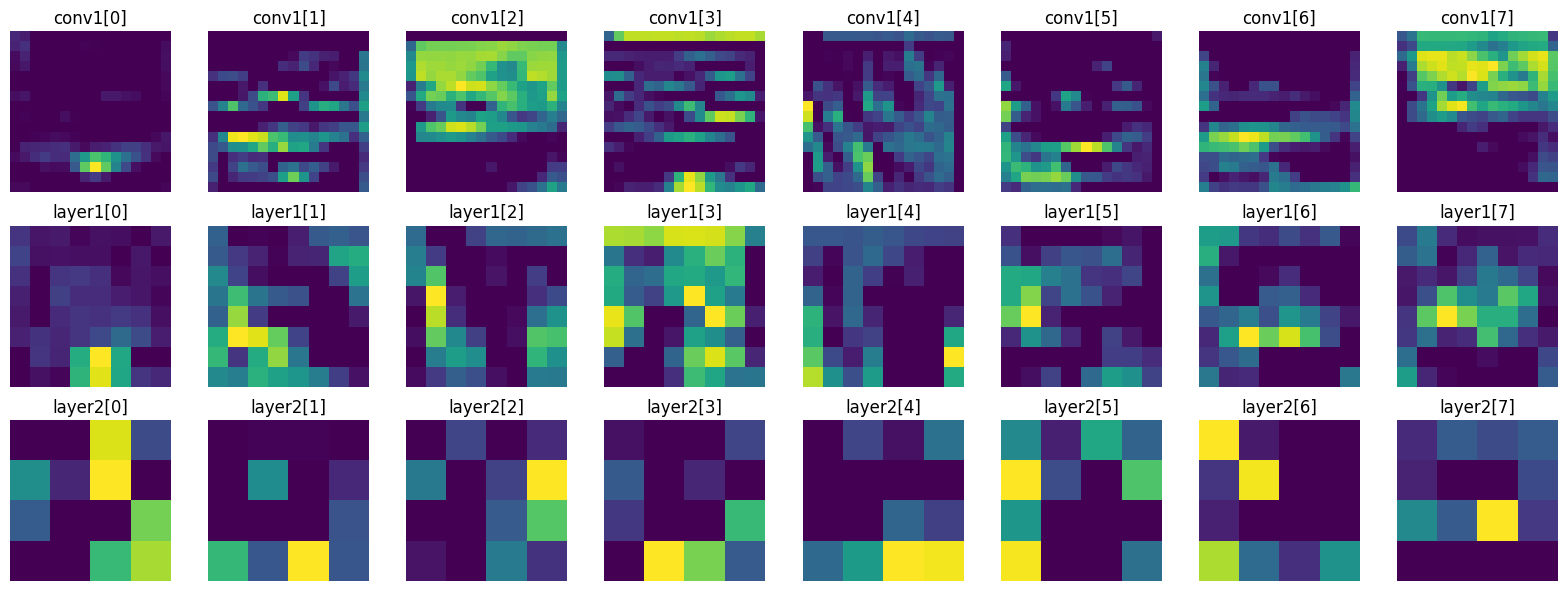

In [155]:
plot_activation_maps_resnet(resnet_4, sample_img)

#### Activation Maps discussion
- The activation maps of ResNet models on the first convolutional layer (with batch norm and relu) show that some appearance of the ship is still visible in the feature maps but not as clear as in my model, probably because ResNet has more and bigger filters in the first conv layer (64 filters of size 7x7) compared to my model (16 filters of size 3x3), making the feature maps more abstract and harder to interpret visually.
- As the image goes deeper into the network, the feature maps become more abstract and less interpretable visually. After the layer1 block, the ship shape is no longer visible, indicating that the model is learning more complex and abstract features from the data.